## ML

In [164]:
import pandas as pd
import numpy as np

from xgboost import XGBRegressor, plot_importance
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

import matplotlib.pyplot as plt
import seaborn as sns

import warnings

warnings.filterwarnings('ignore')

In [136]:
df = pd.read_csv('dataset.csv')

df.head()

,Объем,Бренд,Цена со скидкой,Цена,Тип вина,Цвет,Сахар,Страна производителя,Регион,Аппелласьон,Производитель,Категория,Сорт винограда,Выдержка в ёмкости,Содержание алкоголя,Температура подачи,Friendly,BiO,Винтаж,Подарочная упаковка
0,0.75,Chateau Pinot,580.0,725.0,Тихое,Красное,Сухое,Россия,Краснодарский край,Кубань. Новороссийск ЗГУ,Chateau Pinot,ЗГУ,Пино нуарСаперави,Стальной чан,13.0,17.0,0,0,unknown,0
1,0.75,Bogarve 1915,1160.0,1450.0,Тихое,Красное,Сладкое,Испания,unknown,unknown,Bogarve 1915,unknown,Гарнача тинторера,Бочка,15.0,15.0,0,0,unknown,0
2,0.70,Olymp Winery,470.0,470.0,Тихое,Белое,Полусладкое,Россия,Краснодарский край,unknown,Olymp Winery,unknown,Мускат,unknown,11.0,11.0,0,0,unknown,0
3,0.75,Бурлюк,337.0,421.0,Тихое,Розовое,Полусухое,Россия,Крым,unknown,Бурлюк,unknown,РкацителиМолдова,Стальной чан,10.5,9.0,0,0,unknown,0
4,0.75,Felix Solis Avantis,954.0,1193.0,Тихое,Розовое,Полусухое,Испания,unknown,unknown,Felix Solis Avantis,unknown,ГарначаБобальТемпранильо,Стальной чан,13.0,9.0,0,0,unknown,0


Преобразуем наши данные:

In [104]:
dummies_cols = ['Тип вина', 'Сахар', 'Цвет', 'Страна производителя', 'Регион', 'Категория', 'Выдержка в ёмкости', 'Винтаж']

df_1 = pd.get_dummies(df, columns=dummies_cols)

Разобьем выборку на тренировочную и тестовую:

In [105]:
X = df_1.drop(['Цена', 'Цена со скидкой', 'Бренд', 'Производитель', 'Сорт винограда', 'Аппелласьон'], axis=1)
X.rename(columns={'Винтаж_< 2011': 'Винтаж_less_2011'}, inplace=True)
y = df['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[['Цвет_Красное', 'Цвет_Белое', 'Цвет_Розовое']])

In [106]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print('Linear Regression')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Linear Regression
MSE: 6.304778728632449e+27
MAE: 6600478308228.64


Качество, конечно, ужасное...

Применим регуляризацию в виде Ridge и Lasso:

In [107]:
ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

print('Ridge')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge
MSE: 164400991.9495253
MAE: 6008.2434877563865


In [112]:
lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

print('Lasso')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Lasso
MSE: 165496150.40668932
MAE: 6029.63477109138


С регуляризацией уже совсем другой порядок метрик

Попробуем ансамбли:

In [114]:
from sklearn.ensemble import RandomForestRegressor

rf_model = XGBRegressor()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print('Random Forest')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random Forest
MSE: 127575358.73764952
MAE: 4525.04023437343


In [115]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('XGBoost')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

XGBoost
MSE: 127575358.73764952
MAE: 4525.04023437343


Бустинг и RF из коробки показали себя лучше, чем регрессии, и получили одинаковые метрики

Попробуем подобрать параметры:

In [116]:
ridge_model = Ridge()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Ridge with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge with best params
MSE: 164402024.2889659
MAE: 6008.352025627414


Качество даже чуть хуже стало, не получилось улучшить значительно

In [119]:
rf_model = RandomForestRegressor()

param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('Random forest with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random forest with best params
MSE: 118492277.77180356
MAE: 4194.172451229041


Получилось подобрать параметры, где метрики улучшились

In [126]:
xgb_model = XGBRegressor()

param_grid = {
    'nthread':[4],
    'objective':['reg:linear'],
    'learning_rate': [0.03, 0.05, 0.07, 0.1], 
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [4],
    'silent': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('XGBoost with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

XGBoost with best params
MSE: 123348790.78604035
MAE: 4699.383625548563


Не получилось улучшить XGBoostRegressor прошлый

Попробуем применить One Hot Encoding к категориям, где много различных вариантов, то есть размерность датасета увеличится значительно:

In [127]:
dummies_cols = ['Тип вина', 'Сахар', 'Цвет', 'Страна производителя', 'Регион',
                'Категория', 'Выдержка в ёмкости', 'Винтаж', 'Бренд', 
                'Производитель', 'Сорт винограда', 'Аппелласьон']

df_2 = pd.get_dummies(df, columns=dummies_cols)

Разобьем выборку на тренировочную и тестовую:

In [128]:
X = df_2.drop(['Цена', 'Цена со скидкой'], axis=1)
X.rename(columns={'Винтаж_< 2011': 'Винтаж_less_2011'}, inplace=True)
y = df['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[['Цвет_Красное', 'Цвет_Белое', 'Цвет_Розовое']])

In [129]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print('Linear Regression')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Linear Regression
MSE: 2.9195621780361917e+27
MAE: 17788069468391.254


Качество у линейной регрессии всё так же плохо.

Применим регуляризацию в виде Ridge и Lasso:

In [130]:
ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

print('Ridge')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge
MSE: 129869629.1558833
MAE: 4519.091324000054


In [131]:
lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

print('Lasso')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Lasso
MSE: 162421294.95080844
MAE: 4511.052654934643


Если сравнивать прошлые метрики этих регрессий, то там были в районе 6 тысяч, сейчас они улучшились

Попробуем ансамбли:

In [132]:
from sklearn.ensemble import RandomForestRegressor

rf_model = XGBRegressor()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print('Random Forest')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random Forest
MSE: 107199264.55349097
MAE: 3651.540237301171


In [133]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('XGBoost')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

XGBoost
MSE: 107199264.55349097
MAE: 3651.540237301171


Здесь тоже удалось уменьшить метрики

Попробуем подобрать параметры:

In [134]:
ridge_model = Ridge()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Ridge with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge with best params
MSE: 130039853.77811714
MAE: 4523.345074375487


Качество даже чуть хуже стало, не получилось улучшить значительно

In [135]:
rf_model = RandomForestRegressor()

param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('Random forest with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random forest with best params
MSE: 106343458.99868816
MAE: 3666.084263414569


Получилось подобрать параметры, где метрики улучшились

In [ ]:
xgb_model = XGBRegressor()

param_grid = {
    'nthread':[4],
    'objective':['reg:linear'],
    'learning_rate': [0.03, 0.05, 0.07, 0.1], 
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [4],
    'silent': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('XGBoost with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

### Попробуем убрать строки со слишком высокой ценой

И так как полный One hot encoding показал себя лучше, то будем смотреть по нему

<AxesSubplot:xlabel='Цена'>

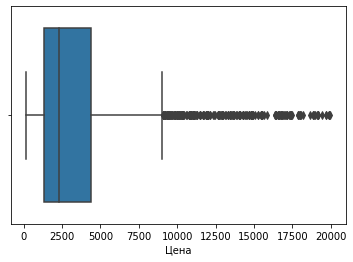

In [138]:
df = df.loc[df['Цена'] < 20000]

sns.boxplot(x=df['Цена'])

<AxesSubplot:xlabel='Цена'>

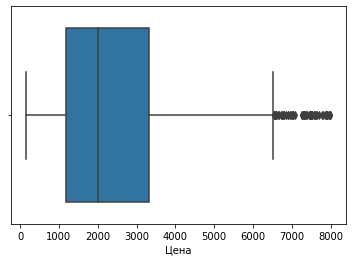

In [141]:
df = df.loc[df['Цена'] < 8000]

sns.boxplot(x=df['Цена'])

In [142]:
dummies_cols = ['Тип вина', 'Сахар', 'Цвет', 'Страна производителя', 'Регион',
                'Категория', 'Выдержка в ёмкости', 'Винтаж', 'Бренд', 
                'Производитель', 'Сорт винограда', 'Аппелласьон']

df_2 = pd.get_dummies(df, columns=dummies_cols)

Разобьем выборку на тренировочную и тестовую:

In [143]:
X = df_2.drop(['Цена', 'Цена со скидкой'], axis=1)
X.rename(columns={'Винтаж_< 2011': 'Винтаж_less_2011'}, inplace=True)
y = df['Цена']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,
                                                    random_state=42,
                                                    stratify=X[['Цвет_Красное', 'Цвет_Белое', 'Цвет_Розовое']])

In [144]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)

y_pred = lr_model.predict(X_test)

print('Linear Regression')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Linear Regression
MSE: 3.8517726614838376e+25
MAE: 2341669356859.7295


Качество у линейной регрессии всё так же плохо.

Применим регуляризацию в виде Ridge и Lasso:

In [145]:
ridge_model = Ridge()

ridge_model.fit(X_train, y_train)

y_pred = ridge_model.predict(X_test)

print('Ridge')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge
MSE: 758494.2607572575
MAE: 604.4530642312944


In [146]:
lasso_model = Lasso()

lasso_model.fit(X_train, y_train)

y_pred = lasso_model.predict(X_test)

print('Lasso')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Lasso
MSE: 822010.1115233914
MAE: 640.9258986697635


Если сравнивать прошлые метрики этих регрессий, то там были в районе 6 тысяч, сейчас они улучшились

Попробуем ансамбли:

In [158]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor()

rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print('Random Forest')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random Forest
MSE: 877559.6980905709
MAE: 593.2170329344935


In [159]:
xgb_model = XGBRegressor()

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print('XGBoost')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

XGBoost
MSE: 816770.167952094
MAE: 617.3713509031963


Здесь тоже удалось уменьшить метрики

Попробуем подобрать параметры:

In [149]:
ridge_model = Ridge()

param_grid = {
    'alpha': [0.001, 0.01, 0.1, 1.0, 10.0],
    'solver': ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
}

grid_search = GridSearchCV(estimator=ridge_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)

print('Ridge with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Ridge with best params
MSE: 758494.2607572522
MAE: 604.4530642313078


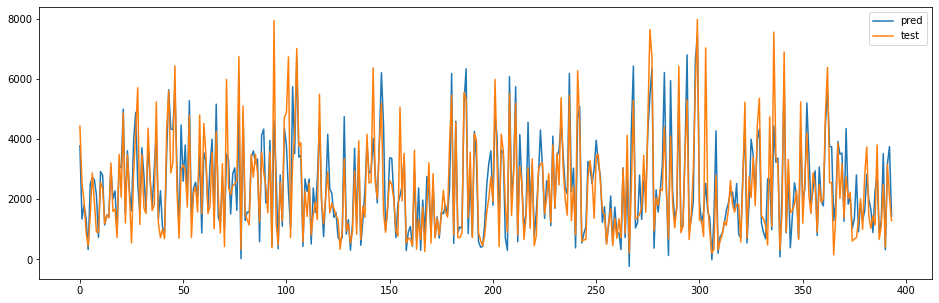

In [154]:
fig = plt.subplots(figsize=(16, 5))
plt.plot(y_pred, label='pred')
plt.plot(y_test.values, label='test')
plt.legend()
plt.show()

In [155]:
rf_model = RandomForestRegressor()

param_grid = {
    'max_depth': [None, 3, 5, 10],
    'min_samples_leaf': [1, 2, 4, 6],
    'max_features': ['auto', 'sqrt', 'log2']
}

grid_search = GridSearchCV(
    estimator=rf_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('Random forest with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Random forest with best params
MSE: 833314.4563973701
MAE: 611.3855064458947


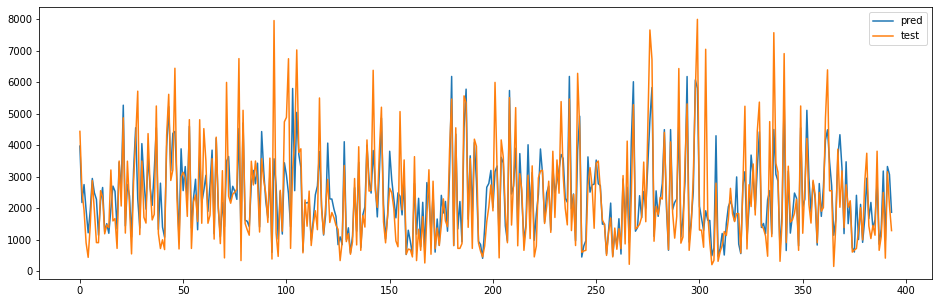

In [156]:
fig = plt.subplots(figsize=(16, 5))
plt.plot(y_pred, label='pred')
plt.plot(y_test.values, label='test')
plt.legend()
plt.show()

In [ ]:
xgb_model = XGBRegressor()

param_grid = {
    'nthread':[4],
    'objective':['reg:linear'],
    'learning_rate': [0.03, 0.05, 0.07, 0.1], 
    'max_depth': [4, 5, 6, 7],
    'min_child_weight': [4],
    'silent': [1],
    'subsample': [0.7],
    'colsample_bytree': [0.7],
    'n_estimators': [100, 300, 500]
}

grid_search = GridSearchCV(
    estimator=xgb_model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=3)
grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print('XGBoost with best params')
print('MSE:', mean_squared_error(y_test, y_pred))
print('MAE:', mean_absolute_error(y_test, y_pred))

Посмотрим на важность признаков:

In [162]:
sorted_idx = np.argsort(rf_model.feature_importances_)[::-1]

for index in sorted_idx[:15]:
    print([X_train.columns[index], rf_model.feature_importances_[index]]) 

['Страна производителя_Россия', 0.11696605000662742]
['Выдержка в ёмкости_Бочка', 0.10148715806203165]
['Содержание алкоголя', 0.08299676068650255]
['Винтаж_unknown', 0.03331459657607195]
['Категория_AOC/AOP', 0.03233527516592389]
['BiO', 0.030001683693676503]
['Объем', 0.019118054583362454]
['Регион_Бургундия', 0.015371142388260423]
['Страна производителя_Италия', 0.01252687053811685]
['Регион_Центральная долина', 0.01139916007809939]
['Аппелласьон_unknown', 0.010635709004415614]
['Сорт винограда_Неббиоло', 0.00984931383932629]
['Производитель_Belmas Winery', 0.009461506484241359]
['Винтаж_2021', 0.009107649715002384]
['Температура подачи', 0.008775107161569224]
